In [3]:
from dataclasses import dataclass
import numpy as np
import mediapy as media
from pathlib import Path
import enum
from tqdm import tqdm
import mujoco

from scipy.ndimage import gaussian_filter1d
from scipy.optimize import minimize
from tqdm import tqdm
import enum

## Helper methods

In [4]:
class Resolution(enum.Enum):
  SD = (480, 640)
  HD = (720, 1280)
  UHD = (2160, 3840)


def quartic(t: float) -> float:
  return 0 if abs(t) > 1 else (1 - t**2) ** 2


def blend_coef(t: float, duration: float, std: float) -> float:
  normalised_time = 2 * t / duration - 1
  return quartic(normalised_time / std)


def unit_smooth(normalised_time: float) -> float:
  return 1 - np.cos(normalised_time * 2 * np.pi)


def azimuth(
    time: float, duration: float, total_rotation: float, offset: float
) -> float:
  return offset + unit_smooth(time / duration) * total_rotation

## Parameters

In [5]:
res = Resolution.SD
fps = 60
duration = 10.0
ctrl_rate = 2
ctrl_std = 0.05
total_rot = 60
blend_std = .8

In [6]:
h, w = res.value

## Loading and rendering the model

In [7]:
model_dir = Path("universal_robots_ur10e")
model_xml = model_dir / "scene_Door.xml"

In [8]:
# Load model.
model = mujoco.MjModel.from_xml_path(str(model_xml))
data = mujoco.MjData(model)

# Make sure offscreen rendering can support the desired resolution.
model.vis.global_.offheight = h
model.vis.global_.offwidth = w

renderer = mujoco.Renderer(model, height=h, width=w)

""

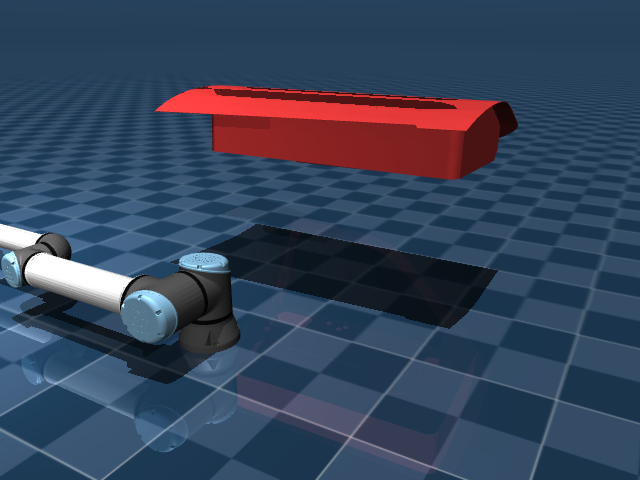

In [9]:
mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

## Checking for keyframes

""

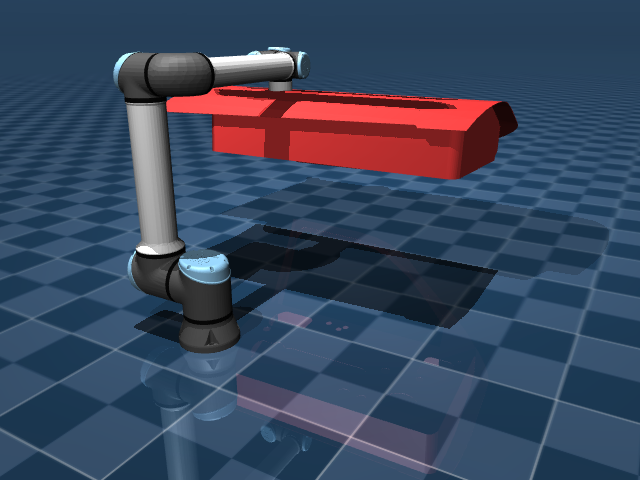

In [10]:
for key in range(model.nkey):
  mujoco.mj_resetDataKeyframe(model, data, key)
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)
  media.show_image(renderer.render())

## Render!

In [11]:
np.random.seed(12345)

timevals = []
angular_velocity = []
q_pos = []

# Hemisphere parameters
hemisphere_center = np.array([0, 0.8, 0])  # Hemisphere center
radius = 0.7                                # Hemisphere radius
theta_limit = np.radians(20)                # Angle limit with the vertical line

# Calculate the total number of frames
total_frames = int(duration * fps)

# Generate trajectory points dynamically based on total_frames
theta = np.linspace(0, 2 * np.pi, int(np.sqrt(total_frames) * 2))  # Horizontal angle
phi = np.linspace(0, theta_limit, int(np.sqrt(total_frames)))     # Vertical angle
theta, phi = np.meshgrid(theta, phi)

# Convert to Cartesian coordinates
x = hemisphere_center[0] + radius * np.sin(phi) * np.cos(theta)
y = hemisphere_center[1] + radius * np.sin(phi) * np.sin(theta)
z = hemisphere_center[2] + radius * np.cos(phi) + 0.1

trajectory_points = np.vstack([x.ravel(), y.ravel(), z.ravel()]).T

# Smooth the trajectory
trajectory_points = gaussian_filter1d(trajectory_points, sigma=2, axis=0)

# Rendering options for visual and collision geometries
vis = mujoco.MjvOption()
vis.geomgroup[2] = True
vis.geomgroup[3] = False
coll = mujoco.MjvOption()
coll.geomgroup[2] = False
coll.geomgroup[3] = True
coll.flags[mujoco.mjtVisFlag.mjVIS_CONVEXHULL] = True

# Create a camera that will revolve around the robot
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 2
camera.elevation = -10
camera.lookat[:] = [0.5, 0.5, 0.4]

frames = []

# Inverse kinematics solver
def compute_inverse_kinematics(model, data, target_pos):
    """Compute inverse kinematics."""
    def objective(q):
        data.qpos[:] = q
        mujoco.mj_forward(model, data)
        ee_pos = data.xpos[ee_site_id]  # End effector position
        return np.linalg.norm(ee_pos - target_pos)

    bounds = [(model.jnt_range[j, 0], model.jnt_range[j, 1]) for j in range(model.nq)]
    result = minimize(objective, data.qpos, bounds=bounds, method="SLSQP")
    if result.success:
        return result.x
    else:
        return None

# Get end-effector site ID
ee_site_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SITE, "ee_site")

# Iterate through trajectory points
for i, point in tqdm(enumerate(trajectory_points[:total_frames]), total=total_frames, desc="Rendering frames"):
    q_desired = compute_inverse_kinematics(model, data, point)
    if q_desired is not None:
        data.qpos[:] = q_desired
        mujoco.mj_forward(model, data)

        timevals.append(data.time)
        # print(f"Frame {i}: Time {data.time:.2f}, Position {point}, Qpos {data.qpos}")
        angular_velocity.append(data.qvel.copy())
        q_pos.append(data.qpos.copy())

        # Adjust camera azimuth dynamically
        camera.azimuth += total_rot / total_frames

        # Render frame
        renderer.update_scene(data, camera, scene_option=vis)
        frame = renderer.render().copy().astype(np.uint8)
        frames.append(frame)
        mujoco.mj_step(model, data)  # update simulation state and time

# Display video
media.show_video(frames, fps=fps, loop=False)

Rendering frames: 100%|██████████| 600/600 [01:34<00:00,  6.32it/s]


In [12]:
# print('positions', data.qpos)
# print('velocities', data.qvel)

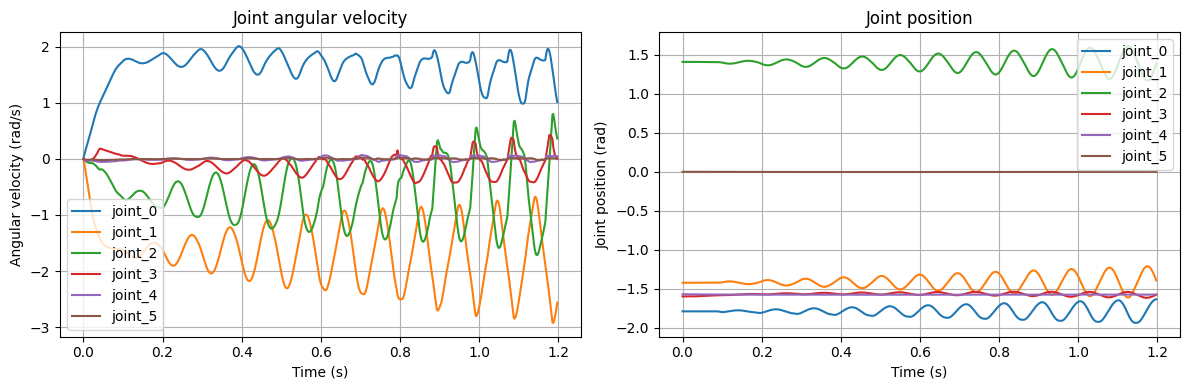

In [13]:
import matplotlib.pyplot as plt
_,ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(timevals, angular_velocity)
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Angular velocity (rad/s)")
ax[0].set_title("Joint angular velocity")
ax[0].legend(['joint_' + str(i) for i in range(model.nv)])
ax[0].grid()
ax[1].plot(timevals, q_pos)
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Joint position (rad)")
ax[1].set_title("Joint position")
ax[1].legend(['joint_' + str(i) for i in range(model.nv)])
ax[1].grid()

plt.tight_layout()
plt.show()